# Informer Demo

## Download code and dataset

In [1]:
# !git clone https://github.com/zhouhaoyi/Informer2020.git
# !git clone https://github.com/zhouhaoyi/ETDataset.git
# !ls

In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [3]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [4]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [5]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.data = 'custom' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.root_path = 'data' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.data_path = '102_Close_diff_perc_nrm.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Close' # target feature in S or MS task
args.freq = 'd' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 100 # input sequence length of Informer encoder
args.label_len = 100 # start token length of Informer decoder
args.pred_len = 50 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.enc_in = 100 # encoder input size
args.dec_in = 7 # decoder input size
args.dec_in = 100 # decoder input size
args.c_out = 7 # output size
args.c_out = 100 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
# args.d_model = 2512 # dimension of model
args.n_heads = 10 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'd'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 4
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [6]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [7]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'custom':{'data':'102_Close_diff_perc_nrm.csv','T':'Close_diff_perc','M':[104,104,104],'S':[1,1,1],'MS':[104,104,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [8]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [9]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': 'data', 'data_path': '102_Close_diff_perc_nrm.csv', 'features': 'MS', 'target': 'Close_diff_perc', 'freq': 'd', 'checkpoints': './informer_checkpoints', 'seq_len': 100, 'label_len': 100, 'pred_len': 50, 'enc_in': 104, 'dec_in': 104, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 10, 'e_layers': 4, 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 4, 'patience': 5, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'd'}


In [10]:
Exp = Exp_Informer

In [11]:
setting = '102_close_diff_perc_nrm_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, 0)

In [12]:
for ii in range(args.itr):
    # setting record of experiments
    

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use CPU
>>>>>>>start training : 102_close_diff_perc_nrm_informer_custom_ftMS_sl100_ll100_pl50_dm512_nh10_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
data_path ->  102_Close_diff_perc_nrm.csv
scaling
data_path ->  102_Close_diff_perc_nrm.csv
scaling
data_path ->  102_Close_diff_perc_nrm.csv
scaling
loss ->  tensor(0.5168, grad_fn=<MeanBackward0>)
loss ->  tensor(1.1438, grad_fn=<MeanBackward0>)
loss ->  tensor(0.5415, grad_fn=<MeanBackward0>)
loss ->  tensor(0.4504, grad_fn=<MeanBackward0>)
loss ->  tensor(0.4600, grad_fn=<MeanBackward0>)
loss ->  tensor(0.2844, grad_fn=<MeanBackward0>)
loss ->  tensor(0.2441, grad_fn=<MeanBackward0>)
loss ->  tensor(0.2692, grad_fn=<MeanBackward0>)
loss ->  tensor(0.2462, grad_fn=<MeanBackward0>)
loss ->  tensor(0.2005, grad_fn=<MeanBackward0>)
loss ->  tensor(0.1997, grad_fn=<MeanBackward0>)
loss ->  tensor(0.1997, grad_fn=<MeanBackward0>)
loss ->  tensor(0.1962, grad_fn=<MeanBackward0>)
loss ->  tensor(0.1723, grad

In [13]:
test_data, test_loader = exp._get_data(flag='test')
# print(testloader.shape)
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
    print(i)
    print(batch_y.shape)

data_path ->  102_Close_diff_perc_nrm.csv
scaling
0
torch.Size([32, 150, 103])
1
torch.Size([32, 150, 103])
2
torch.Size([32, 150, 103])


## Prediction

In [14]:
import os

# set saved model path
# setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl150_ll90_pl15_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl20_ll10_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl30_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl30_dm512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl30_dm512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl30_dm2512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl30_dm2512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl10_dm3512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll200_pl50_dm3512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl400_ll400_pl100_dm2512_nh10_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl100_ll100_pl50_dm2512_nh10_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl100_ll100_pl50_dm512_nh10_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [15]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use CPU
datapath ==  102_Close_diff_perc_nrm.csv
pred_loader length
1
torch.Size([1, 100, 103])


In [16]:
  # the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np


prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 50, 1)

### More details about Prediction - prediction function

In [17]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        print(batch_y.shape)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [18]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

datapath ==  102_Close_diff_perc_nrm.csv
torch.Size([1, 100, 103])


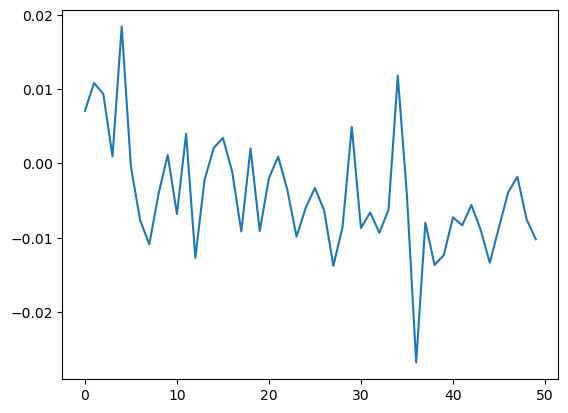

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [20]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [21]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

datapath ==  102_Close_diff_perc_nrm.csv


In [22]:
len(data_set), len(data_loader)

(1, 1)

## Visualization

In [23]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((96, 50, 1), (96, 50, 1))

In [24]:
real_prediction = np.load('./results/'+setting+'/real_prediction.npy')
real_prediction.shape

(1, 50, 1)

In [25]:
print(trues)

[[[-0.2268584 ]
  [ 0.263976  ]
  [ 0.09668539]
  ...
  [ 0.01073663]
  [-0.01213653]
  [ 0.0813728 ]]

 [[ 0.263976  ]
  [ 0.09668539]
  [-0.00898335]
  ...
  [-0.01213653]
  [ 0.0813728 ]
  [-0.5003985 ]]

 [[ 0.09668539]
  [-0.00898335]
  [-0.09799422]
  ...
  [ 0.0813728 ]
  [-0.5003985 ]
  [-0.08712376]]

 ...

 [[-0.04182973]
  [-0.20748255]
  [-0.14171243]
  ...
  [ 0.08233122]
  [-0.10997193]
  [-0.1361915 ]]

 [[-0.20748255]
  [-0.14171243]
  [ 0.06538875]
  ...
  [-0.10997193]
  [-0.1361915 ]
  [ 0.05545529]]

 [[-0.14171243]
  [ 0.06538875]
  [ 0.01271848]
  ...
  [-0.1361915 ]
  [ 0.05545529]
  [-0.12366631]]]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

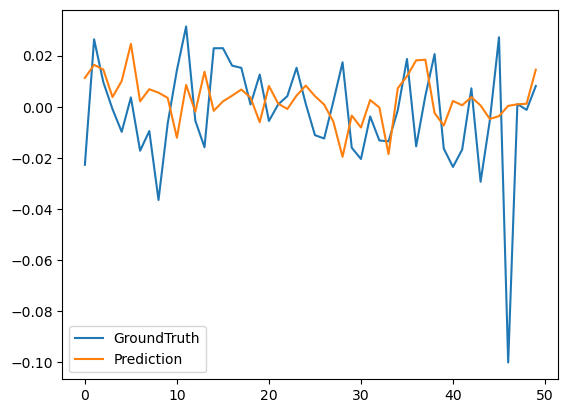

In [30]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1]/10, label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

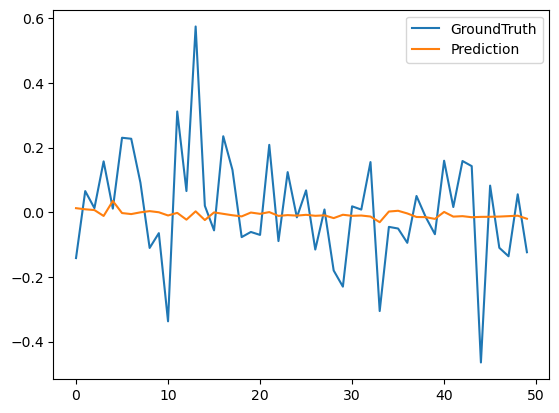

In [28]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[-1,:,0], label='GroundTruth')
plt.plot(preds[-1,:,0], label='Prediction')
plt.legend()
plt.show()

In [29]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

# setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_custom_ftMS_sl200_ll100_pl30_dm2512_nh58_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting='informer_custom_ftMS_sl100_ll100_pl50_dm512_nh10_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

In [ ]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [ ]:
attn[0].shape, attn[1].shape #, attn[2].shape

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './ETDataset/ETT-small/'
args.data_path = 'ETTh2.csv'
# args.data_path = 'final_data.csv'

df1 = pd.read_csv(os.path.join(args.root_path, args.data_path))
for index, row in df1.iterrows():
  print(type(row["date"]))
  break
df1.head()
# df = pd.read_csv(os.path.join(args.data_path))

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
# args.root_path = './ETDataset/ETT-small/'
# args.data_path = 'ETTh2.csv'
args.data_path = 'final_amazon_11_26.csv'

# df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df = pd.read_csv(os.path.join(args.data_path))

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
print (df.dtypes)

In [ ]:
df = df.drop('Unnamed: 0',axis=1)

In [ ]:
# copy the data
df_max_scaled = df.copy()

# apply normalization techniques
for column in df_max_scaled.columns:
    try:
        df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
    except:
        continue
      
# view normalized data
display(df_max_scaled)

In [ ]:
# df_max_scaled.to_csv("normalized_df.csv")
df.to_csv("normalized_df.csv")

In [ ]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'HULL'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]